# Visualizations of Save Our Shores Cleanup Data 2013-2022

The data consisted of 1-2 xslx files per year, with a wide variety of item names, types and site names. Code for data cleanup and plots can be found at https://github.com/jennyfolkesson/cleanupShores

When possible, item categories have a similar stucture to those in the 2023 Monterey Bay National Marine Sanctuary Marine Debris report.

This document will be updated with more graphs as data is further explored.

In [1]:
import circlify
import glob
import numpy as np
import os
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from pprint import pprint
import tabulate

import cleanup as cleanup 
import plots as plots

import plotly.io as pio
from plotly.offline import init_notebook_mode

pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

Read all file and combines them into one if file isn't already saved

In [2]:
data_dir = '/Users/jenny.folkesson/Data/SOS Cleanup Data 2013-2022'
existing_file = glob.glob(os.path.join(data_dir, 'merged_sos_data.csv'))
if len(existing_file) == 1:
    sos_data = pd.read_csv(existing_file[0])
else:
    sos_data = cleanup.merge_data(data_dir)
    sos_data.to_csv(os.path.join(data_dir, "merged_sos_data.csv"), index=False)

Below you can see the structure of the combined 2013-2022 data set. All the columns and the first five rows are on display.

In [3]:
sos_data.head()

,Date,Data Collection,Duration (Hrs),County/City,Cleanup Site,Cleaned Size (Sq Miles),Adult Volunteers,Youth Volunteers,Pounds Of Trash,Pounds Of Recycling,...,Plastic Packaging,Smoking/Tobacco,Straws/Stirrers,Syringes/Needles,Aluminum Foil,Footwear,Shopping Carts,Car Parts,Bikes Or Bike Parts,Car Batteries
0,2013-01-12,NaN,48.0,Watsonville/Santa Cruz County,Manresa State Beach,2,24.0,NaN,20,11,...,1.0,1948.0,7.0,7.0,109.0,59.0,5.0,0.0,0.0,2.0
1,2013-01-12,NaN,70.0,Monterey/Monterey,Del Monte Beach,NaN,35.0,NaN,119,28,...,30.0,10.0,90.0,0.0,16.0,1.0,0.0,0.0,2.0,0.0
2,2013-01-18,NaN,64.0,Santa Cruz/Santa Cruz,New Brighton State Beach,1,32.0,NaN,5,0,...,0.0,0.0,1.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0
3,2013-01-18,NaN,80.0,Santa Cruz/Santa Cruz,Seabright State Beach,NaN,40.0,NaN,40,20,...,NaN,NaN,5.0,NaN,1.0,3.0,NaN,NaN,3.0,NaN
4,2013-01-19,NaN,153.0,Aptos/Santa Cruz,Seacliff State Beach,2,51.0,NaN,33,5,...,10.0,2.0,52.0,2.0,35.0,4.0,0.0,0.0,0.0,0.0


In [4]:
# The 'Other categories are strings and not useful in this analysis
sos_data.drop(['Other.1', 'Other.2', 'Other.3'], axis=1, inplace=True)

## Plot circle packing graph for all items collected 2013-2022

This graph shows the total amount of items of the given categories that have been cleaned up by Save Our Shores from 2013 to 2023. The circle sizes correspond to the number of items. When circles are too small to display the text within them, the text has been removed, and you can instead hover over the circle to see the item category and number.

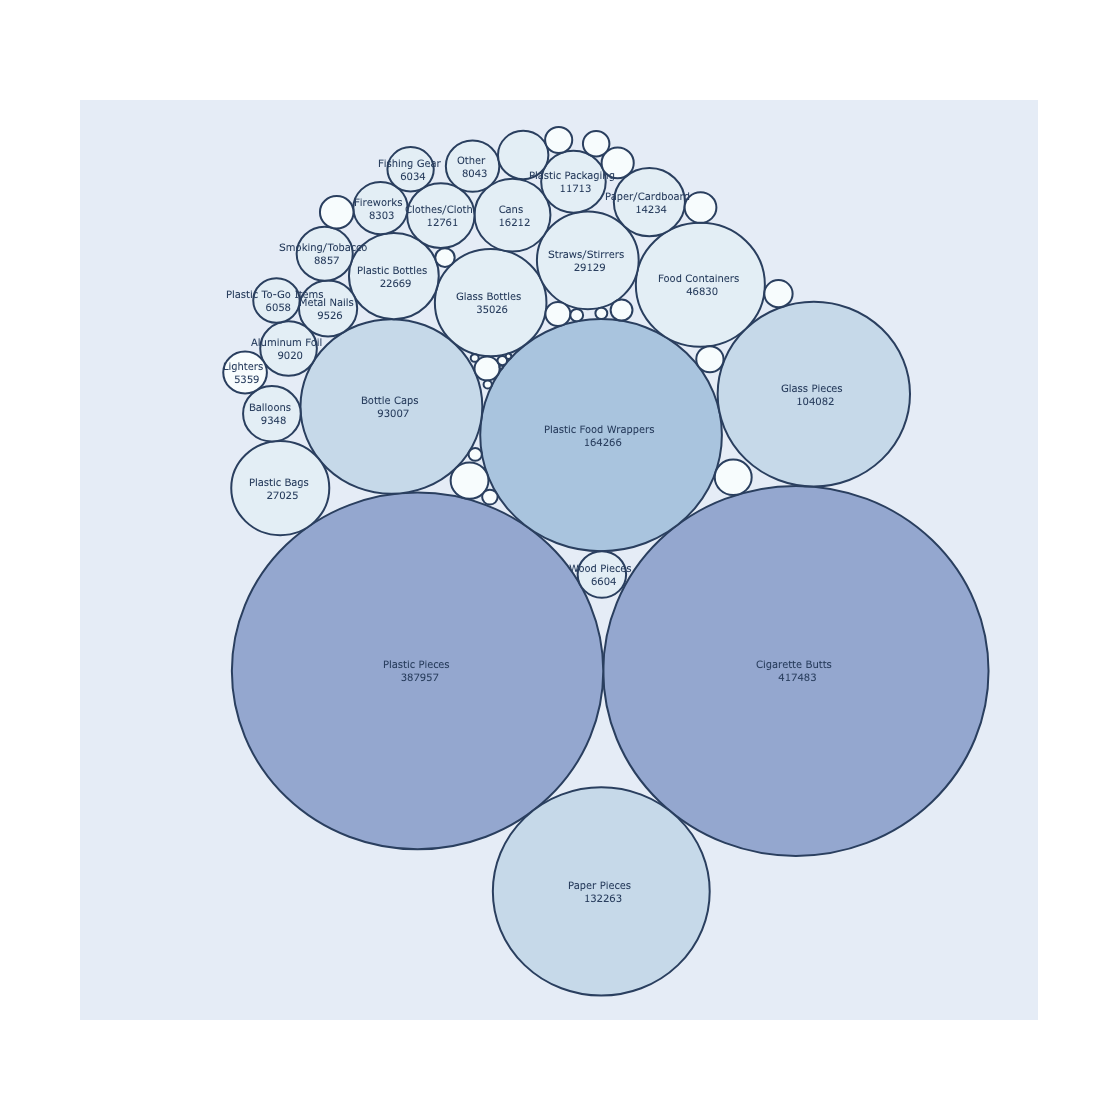

In [5]:
fig = plots.circle_packing_graph(sos_data)
fig.show()

The above graph is a circle packing graph which shows the total number of items cleaned up by Save Our Shores 2013-2022, sorted by the most common categories.

We can show the same information as a treemap, see below.

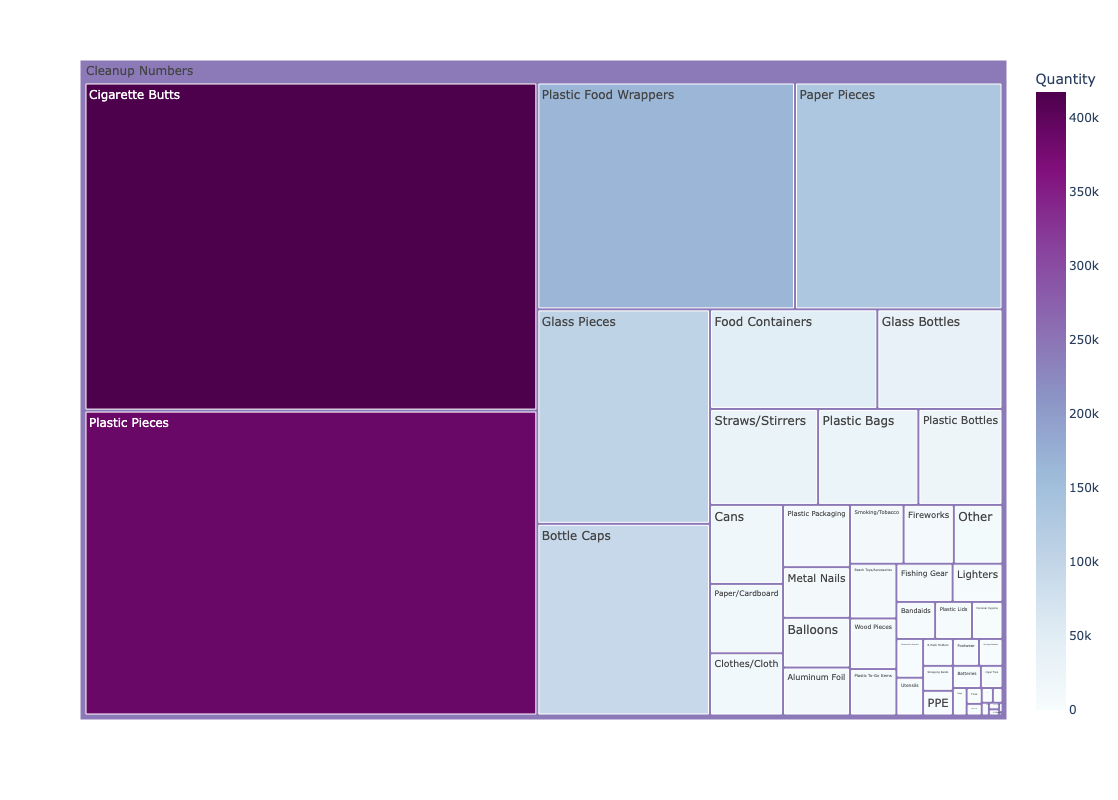

In [6]:
fig = plots.treemap_graph(sos_data)
fig.show()

The treemap graph above shows total number of items cleaned up 2013-2022 by category.

# Explore the Data by Cleanup Site

In the last section we looked at total number of items cleaned up over the years by Save Our Shores. Now we'll look at number of volunteers and number of items cleaned up by site.

There may be some overlap of site names as there were multiple names and spellings for what appeared to be similar sites. Some sites were located by lon, lat coordinates instead of site names, and those are not yet included here.
The code where site names are consolidated is here: https://github.com/jennyfolkesson/cleanupShores/blob/main/cleanup.py#L410

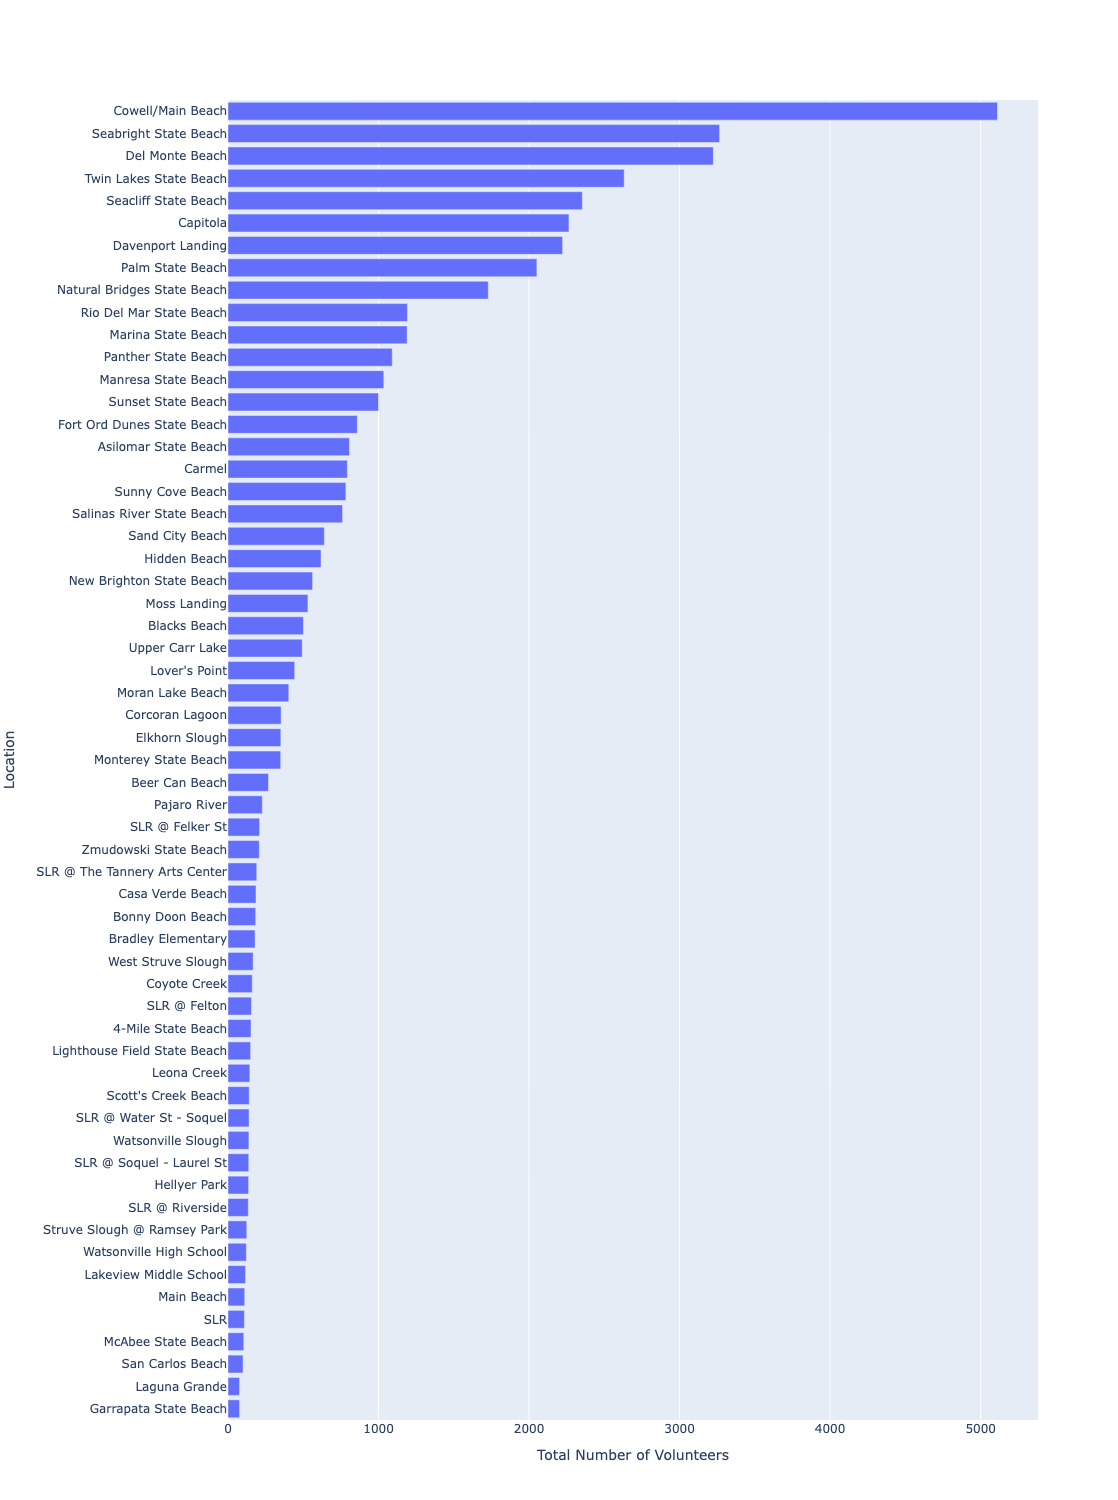

In [7]:
sos_sites = sos_data.copy()
sos_sites = sos_sites.groupby('Cleanup Site').sum()
sos_sites = sos_sites.reset_index()
# NOAA counted youth volunteers as half adult volunteers
sos_sites['Total Volunteers'] = sos_sites['Adult Volunteers'] + 0.5 * sos_sites['Youth Volunteers']
# Drop sites with no stats on volunteer numbers
sos_sites.drop(sos_sites[sos_sites['Total Volunteers'] <= 100].index, inplace=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=sos_sites['Cleanup Site'],
    x=sos_sites['Adult Volunteers'],
    orientation='h',
    name='Total Cleanup Volunteers',
))
fig.update_layout(
    autosize=False,
    width=1100,
    height=1500,
    yaxis_title='Location',
    xaxis_title='Total Number of Volunteers',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

This figure shows the total number of volunteers that have been involved in a cleanup event 2013-2022 per cleanup site. Youth volunteers, when reported, are counted as half an adult volunteer in line with the NOAA Marine Debris Report.
Cleanup sites with less than a total of 100 volunteers are not displayed.

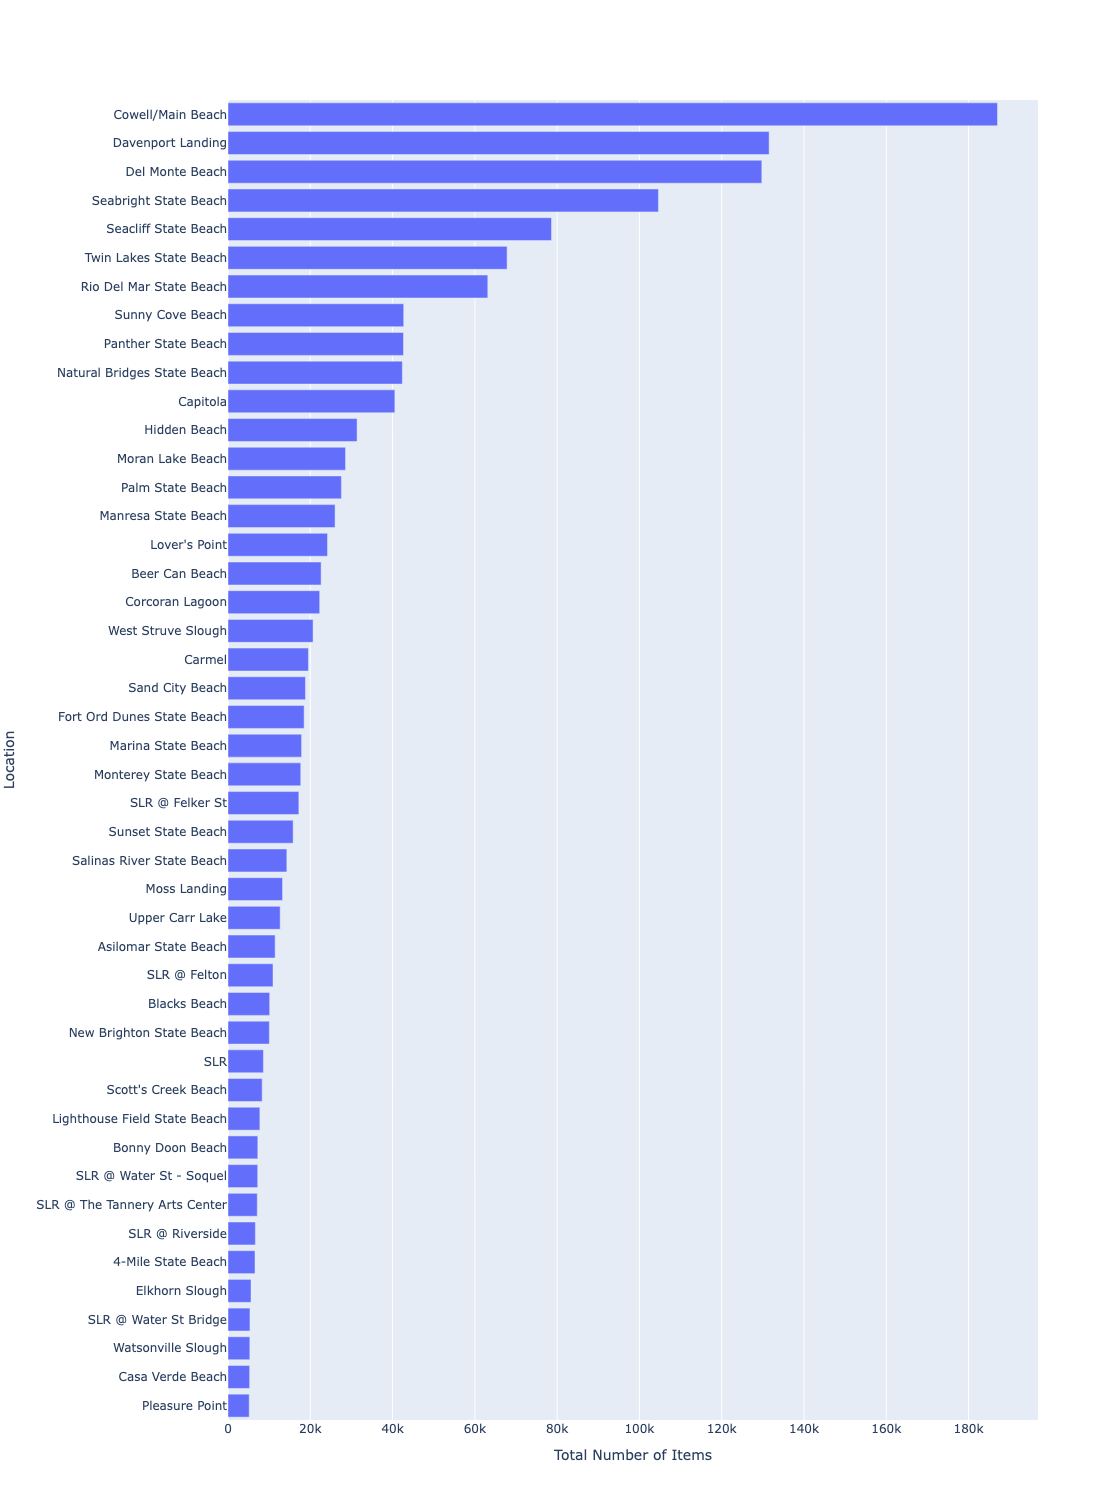

In [8]:
sos_data['Total Items'] = cleanup.sum_items(sos_data, col_sum=False)
sos_sites = sos_data.groupby('Cleanup Site').sum()
sos_sites = sos_sites.reset_index()
# Drop sites with no stats on volunteer numbers
sos_sites.drop(sos_sites[sos_sites['Total Items'] <= 5000].index, inplace=True)

fig = go.Figure()
fig.add_trace(go.Bar(
    y=sos_sites['Cleanup Site'],
    x=sos_sites['Total Items'],
    orientation='h',
    name='Total Number of Items Cleaned Up',
))
fig.update_layout(
    autosize=False,
    width=1100,
    height=1500,
    yaxis_title='Location',
    xaxis_title='Total Number of Items',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

Total number of items cleaned up from 2013-2022 by cleanup site. Sites with less than 5000 items are not displayed.

# Longitudinal Evaluation of Cleanup Items

Here we'll look at the number of items cleaned up every year from 2013-2022. In order to evaluate if the number of items cleaned up are influenced by the number of volunteers and the number of hours they worked we would also need these numbers for each year, but it appears that these numbers are missing for the years 2013-2016 and 2020-2021, at least in the data I've been working with.

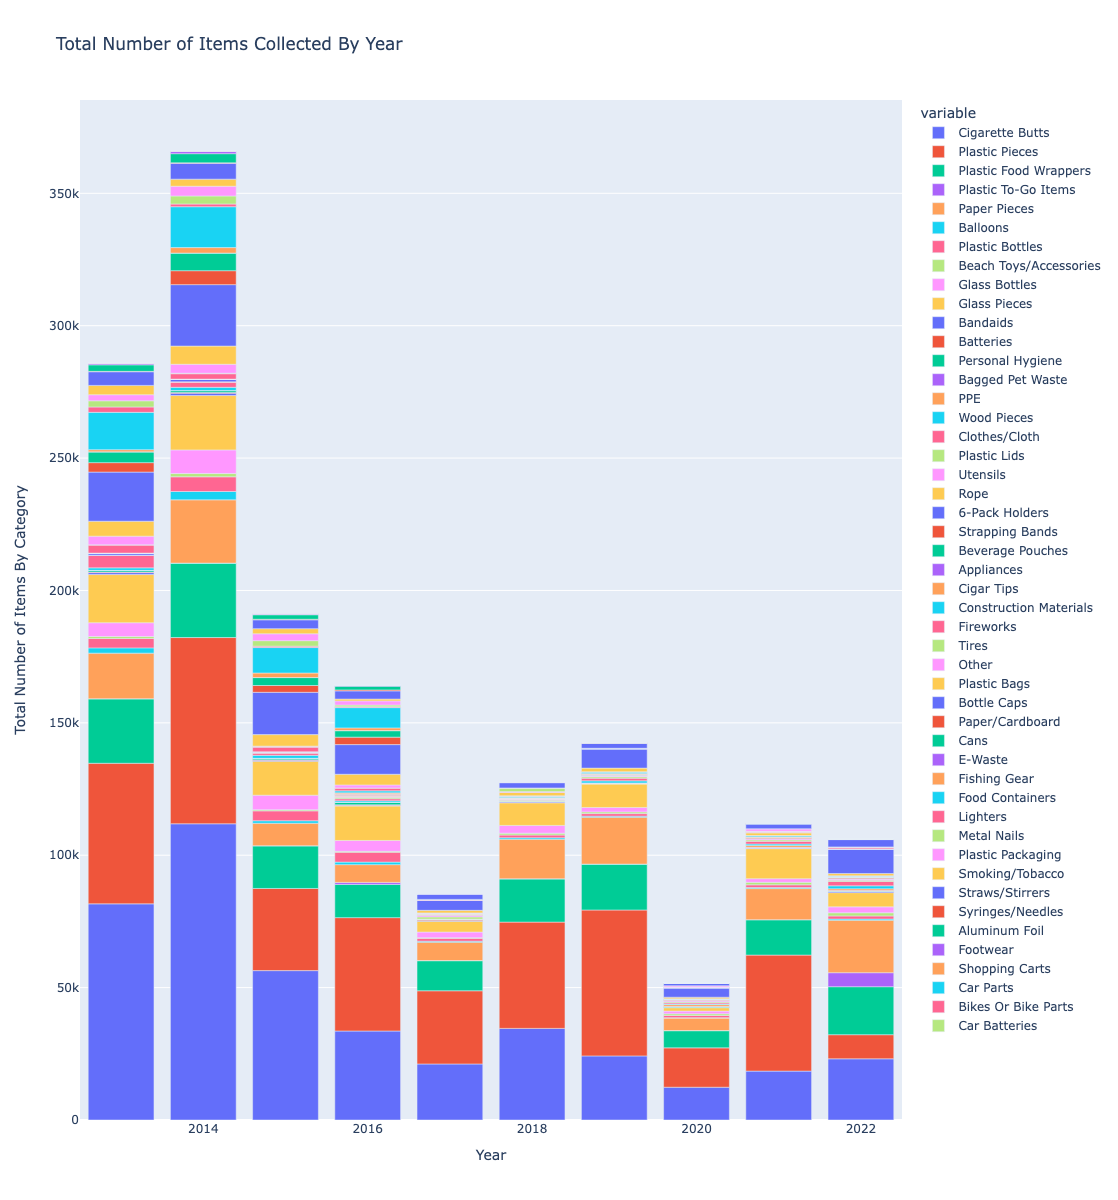

In [12]:
sos_data['Date'] = pd.to_datetime(sos_data['Date'], errors='coerce')
sos_data.dropna(subset=['Date'], inplace=True)

sos_data['Total Volunteers'] = sos_data['Adult Volunteers'] + 0.5 * sos_data['Youth Volunteers']
nonnumeric_cols = cleanup.NONNUMERIC_COLS
nonnumeric_cols.append('Total Volunteers')
nonnumeric_cols.append('Total Items')

volunteers = sos_data.groupby(sos_data.Date.dt.year)['Total Volunteers'].sum()
annual_data = pd.DataFrame({'Year':volunteers.index, 'Total Volunteers':volunteers.values})
annual_data = annual_data.reset_index(drop=True)
item_cols = []
for col in sos_data.columns:
    if col not in cleanup.NONNUMERIC_COLS:
        item_cols.append(col)
        col_sum = sos_data.groupby(sos_data.Date.dt.year)[col].sum()
        col_sum = col_sum.reset_index(drop=True)
        annual_data = pd.concat([annual_data, col_sum], axis=1)

fig = px.bar(annual_data, x='Year', y=item_cols, title="Total Number of Items Collected By Year")
fig.update_layout(
    autosize=False,
    width=1100,
    height=1200,
    yaxis_title='Total Number of Items By Category',
    xaxis_title='Year',
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

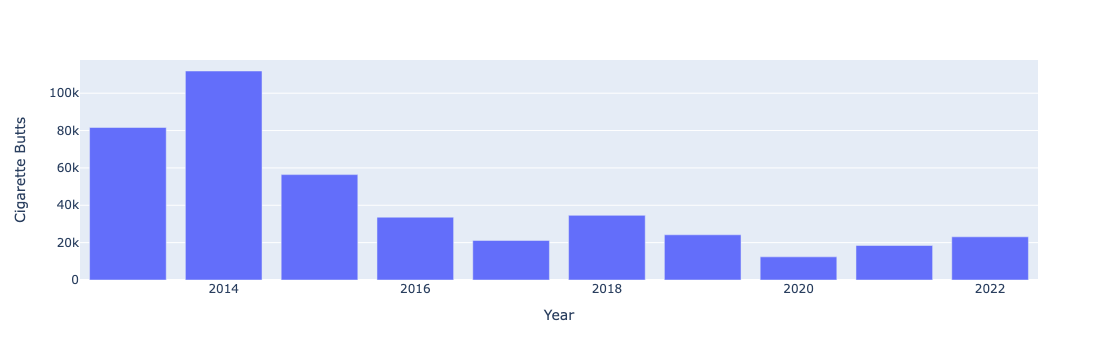

In [10]:
# Cigarette butts only

fig = px.bar(annual_data, x='Year', y='Cigarette Butts')
fig.show()

Above: Total number of cigarette butts collected each year 2013-2022.

In [11]:
fig = px.bar(annual_data, x='Year', y='Total Volunteers')
fig.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Cleanup Time Spent vs Amount of Trash Collected in 2022

Each event has a varying number of adult and youth volunteers, and number of hours spent cleaning up. Since the data on number of volunteers and number of cleanup hours are missing for quite a few years, we'll focus on 2022 only.

In [ ]:
sos_2022 = sos_data[sos_data['Date'].dt.year == 2022]
sos_2022 = sos_2022[cleanup.NONNUMERIC_COLS]
# The marine debris report count youth volunteers as half an adult volunteer
sos_2022['Total Work Hours'] = \
    (sos_2022.fillna(0)['Adult Volunteers'] + 0.5 * sos_2022.fillna(0)['Youth Volunteers']) * \
    sos_2022 .fillna(0)['Duration (Hrs)']
# Remove events that are somehow 0
sos_2022 = sos_2022[sos_2022['Total Work Hours'] > 0]
sos_2022['Youth Work Hours'] =  sos_2022.fillna(0)['Youth Volunteers'] * sos_2022.fillna(0)['Duration (Hrs)']
sos_2022['Adult Work Hours'] =  sos_2022.fillna(0)['Adult Volunteers'] * sos_2022.fillna(0)['Duration (Hrs)']
# Assuming here that recycling is weighed with trash for the rows where yellow fields are filled
sos_2022['Pounds Of Trash'] = pd.to_numeric(sos_2022['Pounds Of Trash'], errors='coerce')
sos_2022['Pounds Of Recycling'] = pd.to_numeric(sos_2022['Pounds Of Recycling'], errors='coerce')
sos_2022['Total Pounds Of Trash'] = \
    sos_2022.fillna(0)['Pounds Of Trash'] + sos_2022.fillna(0)['Pounds Of Recycling']
sos_2022 = sos_2022[sos_2022['Total Pounds Of Trash'] > 1]

fig.data = []
fig = px.scatter(sos_2022, 
                 x=['Youth Work Hours', 'Adult Work Hours'], 
                 y='Total Pounds Of Trash', 
                 trendline="ols")
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    yaxis_title='Total Amount of Trash/Recycling (lbs)',
    xaxis_title='Total Cleanup Time (h)',
)
fig.show()

There are clearly some outliers here that are worth investigating, but for now we'll focus on getting the coefficient of determination and p-value for youth and adult work hours vs amount of trash.

In [ ]:
results = px.get_trendline_results(fig)

stats = [["", "Youth", "Adult"],
         ["R Squared", "", ""],
         ["p-value", "", ""],
         ["f(x)", "", ""]]

for idx in range(2):
    stats[1][idx + 1] = "{:.5f}".format(results.px_fit_results[idx].rsquared)
    stats[2][idx + 1] = "{}".format(results.px_fit_results[idx].pvalues[1])
    params = results.px_fit_results[idx].params
    stats[3][idx + 1] = "{:.1f}x + {:.1f}".format(params[1], params[0])

table = tabulate.tabulate(stats, tablefmt='html')
table

There's a significant correlation between hours worked and pounds of trash collected for adults but not for youth.
'Youth' might include children as well as teenagers, so it makes sense that that group would collect less trash.
It might be worth investigating the data and its outliers before drawing any conclusions.